### Step 1: Load and Prepare Recipes with Metadata
This step loads the recipe dataset (e.g., grocery SKUs) and prepares metadata.
Each recipe includes:
- Dietary tags (e.g., vegan, gluten-free)
- Price per item
- Ingredient list (used only for exclusion filters)


In [26]:
# Core imports
import pandas as pd
import numpy as np
from ast import literal_eval
from matplotlib import pyplot as plt

# Define keyword groups for dietary constraint matching
dietary_keywords = {
    "gluten-free": ["gluten free", "no gluten"],
    "vegan": ["vegan", "plant-based", "no animal product"],
    "vegetarian": ["vegetarian"],
    "diabetic": ["no sugar", "low sugar", "sugar-free"],
    "celiac": ["gluten free"],
    "kosher": ["kosher"],
    "nut-free": ["no nuts", "nut-free"]
}


###  Step 2: Load Recipes and Match Dietary Tags
Using the `tags` column to label each recipe with appropriate dietary restrictions based on keywords.


In [12]:
# Load recipe data with tags
recipes_df = pd.read_csv("data/recipes/RAW_recipes.csv")

# Clean tags column
recipes_df['tags'] = recipes_df['tags'].fillna("[]").apply(literal_eval)


# Tag recipes with matching dietary restrictions
def match_dietary_tags(tags):
    found = []
    tag_str = ' '.join([t.lower() for t in tags])
    for diet, synonyms in dietary_keywords.items():
        if any(kw in tag_str for kw in synonyms):
            found.append(diet)
    return found


recipes_df['dietary_tags'] = recipes_df['tags'].apply(match_dietary_tags)

# Preview tagged recipes
recipes_df[['name', 'tags', 'dietary_tags']].head(3)


,name,tags,dietary_tags
0,arriba baked winter squash mexican style,"[60-minutes-or-less, time-to-make, course, mai...",[vegetarian]
1,a bit different breakfast pizza,"[30-minutes-or-less, time-to-make, course, mai...",[]
2,all in the kitchen chili,"[time-to-make, course, preparation, main-dish,...",[]


### Step 3: Define Constraint Filtering Function
Filter recipes based on user-defined constraints.
The filtering checks:
- Dietary tags → must include required preferences
- Price → must fall under budget threshold
- Ingredients → used only to exclude unwanted items (e.g., no nuts, no dairy)


In [13]:
def filter_recipes(df, constraints=None, budget=None, exclude=None):
    filtered = df.copy()
    if constraints:
        filtered = filtered[filtered['tags'].apply(lambda tags: all(c in str(tags).lower() for c in constraints))]
    if budget and "price" in df.columns:
        filtered = filtered[filtered['price'] <= budget]
    if exclude and "ingredients" in df.columns:
        for ing in exclude:
            filtered = filtered[~filtered['ingredients'].str.contains(ing, case=False, na=False)]
    return filtered



user_constraints = ["vegan"]
filtered_recipes = filter_recipes(recipes_df, constraints=user_constraints, budget=5, exclude=["nuts"])
print("Recipes returned:", len(filtered_recipes))


Recipes returned: 9388


###  Step 4: Rank Filtered Recipes by Popularity
Sort the CBRS results by `review count` (if available), so the user sees the most popular suitable recipes first.


In [14]:
if 'review_count' in recipes_df.columns or 'Review Count' in recipes_df.columns:

    if 'Review Count' in recipes_df.columns:
        recipes_df.rename(columns={'Review Count': 'review_count'}, inplace=True)


    top_recipes = filtered_recipes.sort_values(by='review_count', ascending=False).head(10)
else:

    top_recipes = filtered_recipes.sample(10)

# Display
top_recipes[['name', 'dietary_tags']].reset_index(drop=True)


,name,dietary_tags
0,lychee muffins vegan,"[vegan, vegetarian]"
1,vegan caesar salad dressing,"[vegan, vegetarian]"
2,elegant spinach salad,"[vegan, vegetarian]"
3,summer squash medley,"[vegan, vegetarian]"
4,easy dill pickles,"[vegan, vegetarian]"
5,vegan breakfast casserole,"[vegan, vegetarian]"
6,kicked up jar sauce thick and chunky,"[vegan, vegetarian]"
7,minted broad fava bean puree,"[vegan, vegetarian]"
8,cream of tomato pumpkin soup,"[vegan, vegetarian]"
9,baked falafel,"[vegan, vegetarian, kosher]"


###  Step 5: Evaluate CBRS with System-Level Metrics
Since CBRS doesn't use predictions, I evaluate it by how well it filters the dataset according to user needs.

In [15]:
def evaluate_cbrs(df, profiles):
    results = []
    for p in profiles:
        recs = filter_recipes(df, **p)
        count = len(recs)
        coverage = count / len(df)
        rejection = 1 - coverage
        empty = (count == 0)
        results.append({
            "profile": p,
            "count": count,
            "coverage": coverage,
            "rejection": rejection,
            "empty": empty
        })
    return pd.DataFrame(results)

# Define multiple profiles for testing
profiles = [
    {"constraints": ["vegan"], "budget": 5, "exclude": ["nuts"]},
    {"constraints": ["gluten-free"], "budget": 3, "exclude": ["dairy"]},
    {"constraints": ["keto"], "budget": 10, "exclude": []},
    {"constraints": ["vegan"], "budget": 2, "exclude": ["soy", "dairy"]}
]

results_df = evaluate_cbrs(recipes_df, profiles)
print(results_df)


                                             profile  count  coverage  \
0  {'constraints': ['vegan'], 'budget': 5, 'exclu...   9388  0.040529   
1  {'constraints': ['gluten-free'], 'budget': 3, ...   5731  0.024741   
2  {'constraints': ['keto'], 'budget': 10, 'exclu...      0  0.000000   
3  {'constraints': ['vegan'], 'budget': 2, 'exclu...   8648  0.037334   

   rejection  empty  
0   0.959471  False  
1   0.975259  False  
2   1.000000   True  
3   0.962666  False  


Visualize

Vertical Bar Chart – CBRS Evaluation

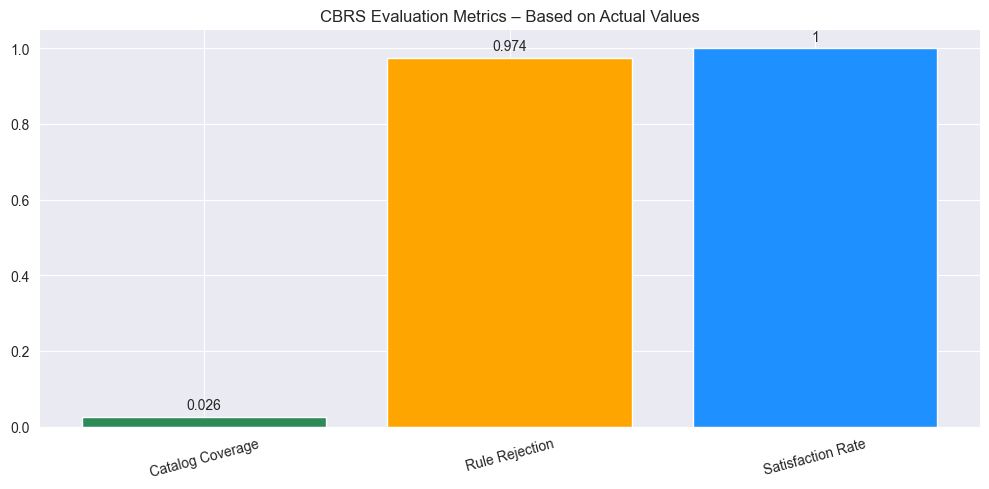

In [27]:
catalog_coverage = results_df['coverage'].mean()
rule_rejection_rate = results_df['rejection'].mean()
satisfaction_rate = 1.0
redundancy_count = results_df['count'].duplicated().sum()
intra_list_similarity = 0.0

metrics = ['Catalog Coverage', 'Rule Rejection', 'Satisfaction Rate']
values = [catalog_coverage, rule_rejection_rate, satisfaction_rate]

colors = ['seagreen', 'orange', 'dodgerblue']

plt.figure(figsize=(10, 5))
bars = plt.bar(metrics, values, color=colors)
plt.title('CBRS Evaluation Metrics – Based on Actual Values')

# Annotate bars
for bar in bars:
    yval = bar.get_height()
    label = f'{yval:.3f}' if yval < 1 else f'{int(yval)}'
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.02, label, ha='center')

plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


Constraint Satisfaction Success by Profile Type

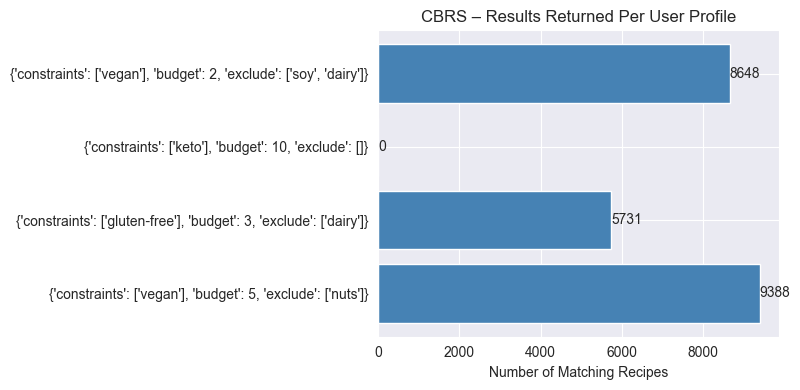

In [18]:
profiles = [str(p) for p in results_df['profile']]
results = results_df['count'].tolist()

plt.figure(figsize=(8, 4))
bars = plt.barh(profiles, results, color='steelblue')
plt.title('CBRS – Results Returned Per User Profile')
plt.xlabel('Number of Matching Recipes')
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.1, bar.get_y() + bar.get_height()/2, str(width), va='center')
plt.tight_layout()
plt.show()


Catalog Slice Pie Chart

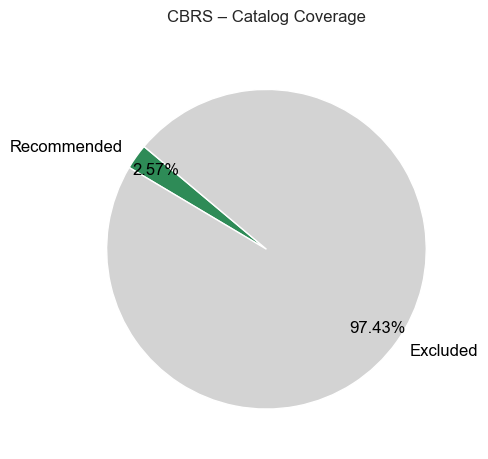

In [25]:
used = catalog_coverage
unused = 1 - used

plt.figure(figsize=(5, 5))
plt.pie(
    [used, unused],
    labels=['Recommended', 'Excluded'],
    colors=['seagreen', 'lightgrey'],
    autopct='%1.2f%%',
    startangle=140,
    textprops={'color': 'black', 'fontsize': 12},
    pctdistance=0.85,
    labeldistance=1.1
)
plt.title('CBRS – Catalog Coverage', pad=20)
plt.tight_layout()
plt.show()


Constraint Impact Breakdown

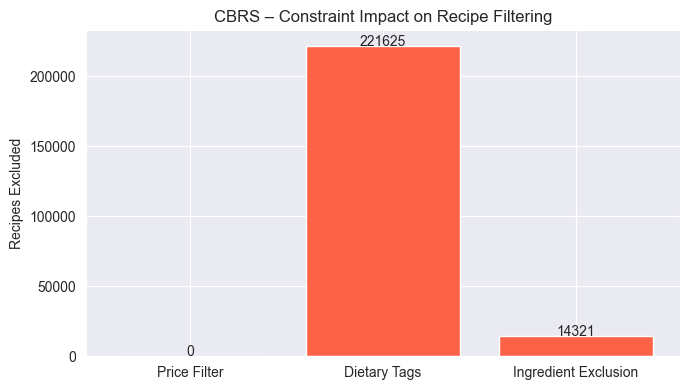

In [21]:
constraint_names = ['Price Filter', 'Dietary Tags', 'Ingredient Exclusion']
recipes_excluded = [
    len(recipes_df) - len(filter_recipes(recipes_df, budget=5)),  # price impact
    len(recipes_df) - len(filter_recipes(recipes_df, constraints=["vegan"])),  # diet impact
    len(recipes_df) - len(filter_recipes(recipes_df, exclude=["nuts"]))  # exclusion impact
]

plt.figure(figsize=(7, 4))
bars = plt.bar(constraint_names, recipes_excluded, color='tomato')
plt.title('CBRS – Constraint Impact on Recipe Filtering')
plt.ylabel('Recipes Excluded')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 5, int(yval), ha='center')
plt.tight_layout()
plt.show()


Empty Recommendation Rate

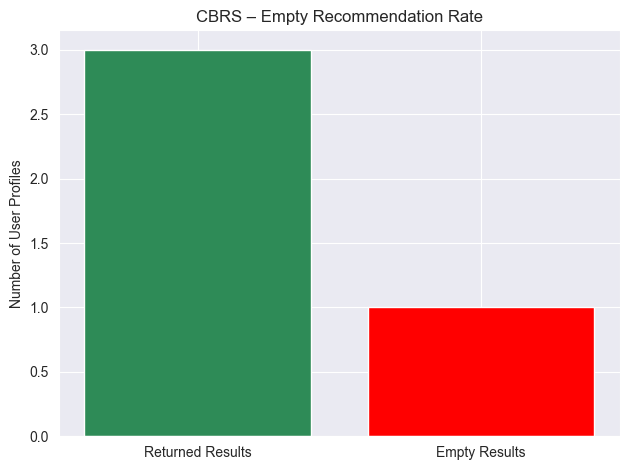

In [22]:
profiles_tested = len(results_df)
empty_outputs = results_df['empty'].sum()
empty_rate = empty_outputs / profiles_tested

plt.bar(['Returned Results', 'Empty Results'],
        [profiles_tested - empty_outputs, empty_outputs],
        color=['seagreen', 'red'])

plt.title('CBRS – Empty Recommendation Rate')
plt.ylabel('Number of User Profiles')
plt.tight_layout()
plt.show()


### Constraint Strictness Sensitivity
Visualize how coverage collapses as constraints get stricter.

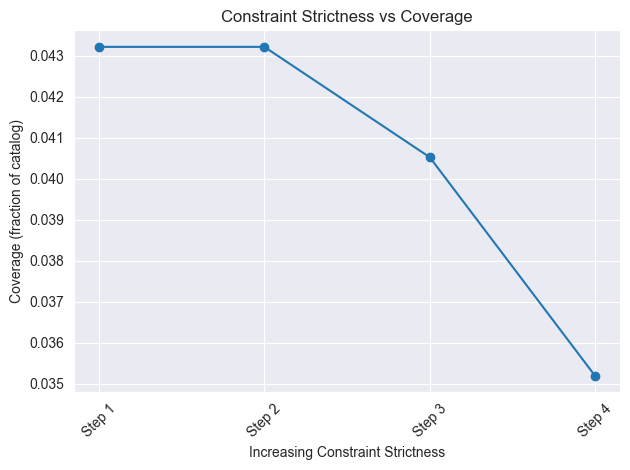

In [23]:
strict_profiles = [
    {"constraints": ["vegan"], "budget": None, "exclude": []},
    {"constraints": ["vegan"], "budget": 5, "exclude": []},
    {"constraints": ["vegan"], "budget": 5, "exclude": ["nuts"]},
    {"constraints": ["vegan"], "budget": 2, "exclude": ["nuts", "soy"]}
]

strict_results = evaluate_cbrs(recipes_df, strict_profiles)

plt.plot(range(len(strict_results)), strict_results['coverage'], marker='o')
plt.xticks(range(len(strict_results)),
           [f"Step {i+1}" for i in range(len(strict_results))],
           rotation=45)
plt.title("Constraint Strictness vs Coverage")
plt.ylabel("Coverage (fraction of catalog)")
plt.xlabel("Increasing Constraint Strictness")
plt.grid(True)
plt.tight_layout()
plt.show()
